In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [9]:
def flatten(x): return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), # 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.7857359375, tensor(0.3907)]
valid: [0.896196875, tensor(0.6895)]
CPU times: user 49.7 s, sys: 47.5 s, total: 1min 37s
Wall time: 13.6 s


## Cuda

In [15]:
device = torch.device('cuda', 0)

In [16]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [17]:
torch.cuda.set_device(device)

In [18]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [1.95954015625, tensor(0.3127, device='cuda:0')]
valid: [1.5812974609375, tensor(0.4722, device='cuda:0')]
train: [0.492788984375, tensor(0.8442, device='cuda:0')]
valid: [0.25984951171875, tensor(0.9162, device='cuda:0')]
train: [0.22395021484375, tensor(0.9318, device='cuda:0')]
valid: [0.16464228515625, tensor(0.9480, device='cuda:0')]
CPU times: user 4.37 s, sys: 1.7 s, total: 6.07 s
Wall time: 23 s


## Refactor model

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [25]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
nfs = [8, 16, 32, 32]

In [160]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [161]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.4, cbs=cbfs)

In [30]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
run.fit(3, learn)

train: [1.60802546875, tensor(0.4715, device='cuda:0')]
valid: [0.42239794921875, tensor(0.8756, device='cuda:0')]
train: [0.305320078125, tensor(0.9069, device='cuda:0')]
valid: [0.1819533203125, tensor(0.9478, device='cuda:0')]
train: [0.16892140625, tensor(0.9488, device='cuda:0')]
valid: [0.1235017333984375, tensor(0.9626, device='cuda:0')]


## Hooks

### Manual insertion

In [67]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.mean())
                self.act_stds[i].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [68]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

In [69]:
run.fit(2, learn)

train: [1.64674171875, tensor(0.4206, device='cuda:0')]
valid: [0.47879189453125, tensor(0.8474, device='cuda:0')]
train: [0.3351357421875, tensor(0.8968, device='cuda:0')]
valid: [0.231998876953125, tensor(0.9321, device='cuda:0')]


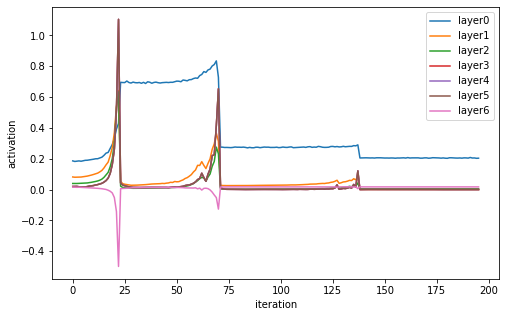

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
for l, m in enumerate(model.act_means): 
    ax.plot(m, label=f"layer{l}")
    ax.legend()
    ax.set_xlabel('iteration')
    ax.set_ylabel('activation');

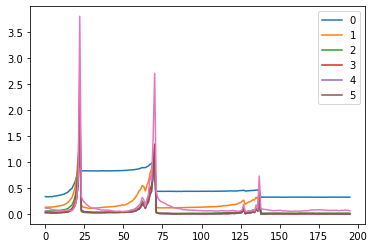

In [36]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

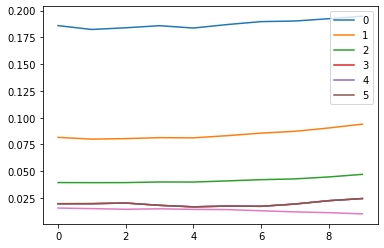

In [37]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

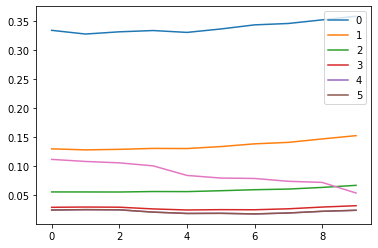

In [38]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

### Pytorch hooks

In [39]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.5, cbs=cbfs)

In [40]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [41]:
def append_stats(i, m, inp, outp):
    if m.training:
        act_means[i].append(outp.data.mean())
        act_stds[i].append(outp.data.std())

In [42]:
for i, l in enumerate(model):
    l.register_forward_hook(partial(append_stats, i))

In [43]:
run.fit(1, learn)

train: [2.3003721875, tensor(0.1513, device='cuda:0')]
valid: [2.278967578125, tensor(0.1688, device='cuda:0')]


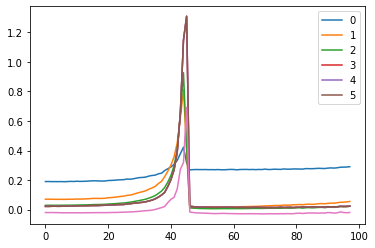

In [44]:
for o in act_means: plt.plot(o)
plt.legend(range(6))

### Hook class

In [70]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds.append(outp.data.std())

In [46]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [47]:
hooks = [Hook(m, append_stats) for m in model[:4]]

In [48]:
run.fit(1, learn)

train: [2.3051328125, tensor(0.1466, device='cuda:0')]
valid: [2.3529646484375, tensor(0.2652, device='cuda:0')]


Text(0.5, 1.0, 'Activation Mean')

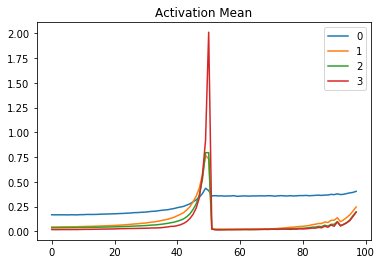

In [49]:
for h in hooks: plt.plot(h.stats[0])
plt.legend(range(4))
plt.title('Activation Mean')

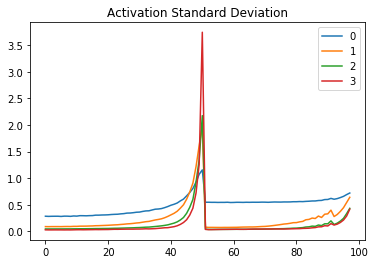

In [50]:
for h in hooks: plt.plot(h.stats[1])
plt.legend(range(4))
plt.title('Activation Standard Deviation');

### A Hooks class

In [51]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                assert len(idx) == len(self)
                return [v for m, v in zip(idx, self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, v): self.items[i] = v
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): 
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [52]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [53]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [54]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [55]:
t[tensor(3)]

3

In [75]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [90]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [58]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fbd4042ac50>, <__main__.Hook object at 0x7fbd40466630>, <__main__.Hook object at 0x7fbd40466a90>, <__main__.Hook object at 0x7fbd40466ef0>, <__main__.Hook object at 0x7fbd40466b00>, <__main__.Hook object at 0x7fbd40466550>, <__main__.Hook object at 0x7fbd404669b0>]

In [59]:
hooks.remove()

In [60]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [61]:
x.mean(), x.std()

(tensor(-0.0135, device='cuda:0'), tensor(0.9846, device='cuda:0'))

In [62]:
p = model[0](x)

In [63]:
p.mean(), p.std()

(tensor(0.1859, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.3737, device='cuda:0', grad_fn=<StdBackward0>))

In [91]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [65]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4003, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.7512, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.6522128125, tensor(0.4429, device='cuda:0')]
valid: [0.3472105224609375, tensor(0.8979, device='cuda:0')]
train: [0.29145853515625, tensor(0.9103, device='cuda:0')]
valid: [0.173057373046875, tensor(0.9486, device='cuda:0')]


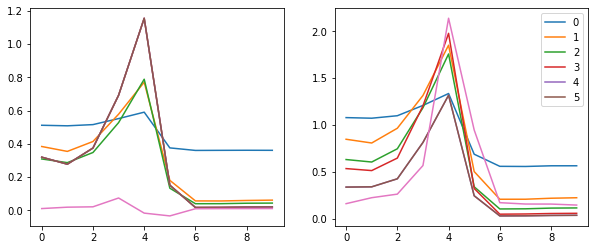

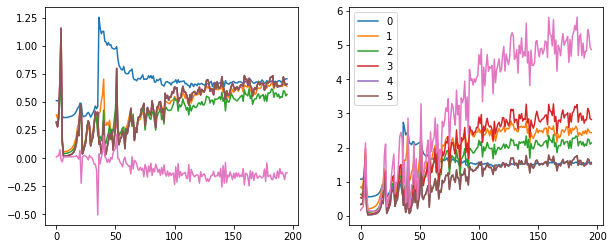

In [92]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        axs[0].plot(ms[:10])
        axs[1].plot(ss[:10])
    plt.legend(range(6))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        axs[0].plot(ms)
        axs[1].plot(ss)
    plt.legend(range(6))

### Other statistics

In [162]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40, 0, 10))

In [172]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

In [173]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [174]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.8876428125, tensor(0.3441, device='cuda:0')]
valid: [0.66041103515625, tensor(0.7693, device='cuda:0')]


In [175]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

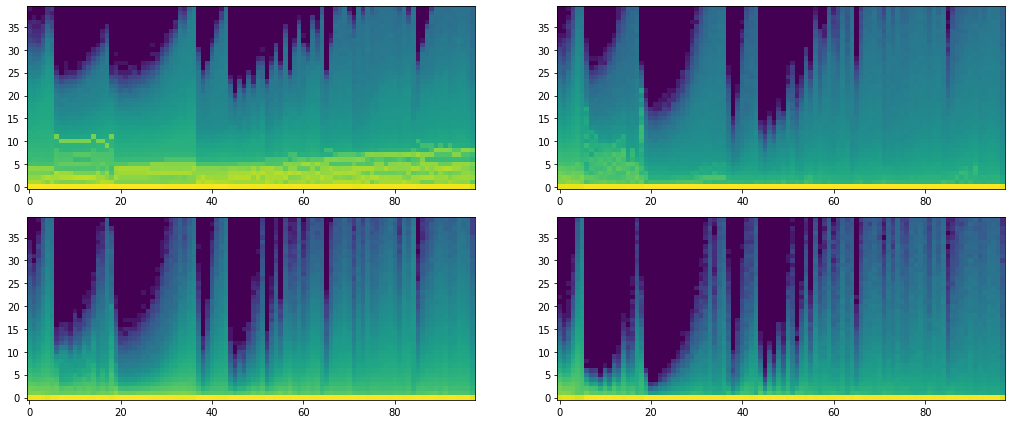

In [176]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axs.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    #ax.axis('off')
plt.tight_layout()

In [177]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0) / h1.sum(0)

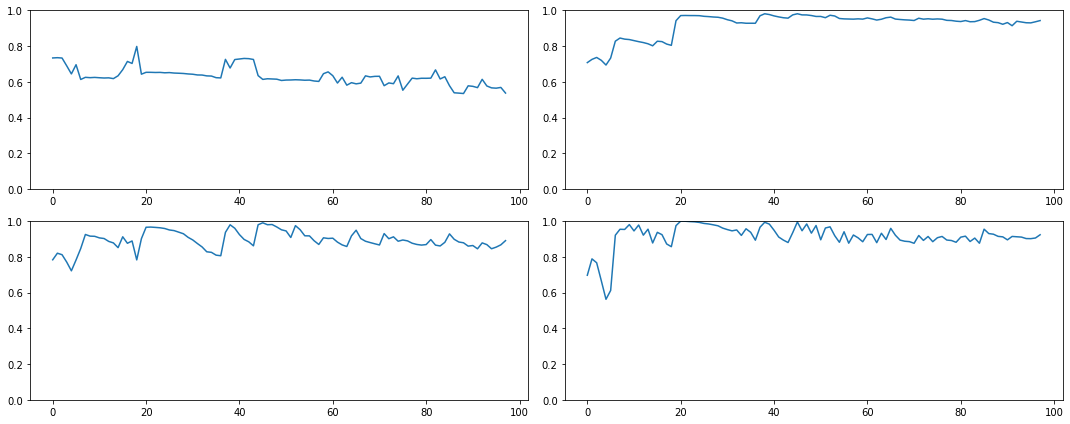

In [178]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axs.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(bottom=0, top=1)
plt.tight_layout()

## Generalized ReLU

In [187]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs) 
            for i in range(len(nfs) - 1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
        GeneralRelu(**kwargs)
    )

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [188]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds.append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40, -7, 7))

In [189]:
model = get_cnn_model(data, nfs, conv_layer, leak=.1, sub=.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

train: [0.4998769921875, tensor(0.8458, device='cuda:0')]
valid: [0.16171837158203126, tensor(0.9480, device='cuda:0')]


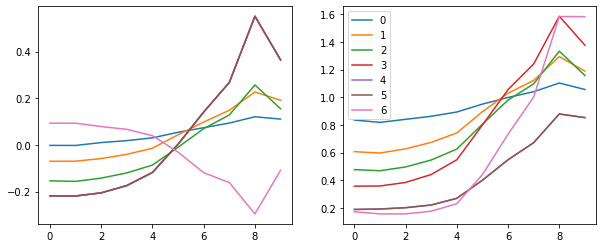

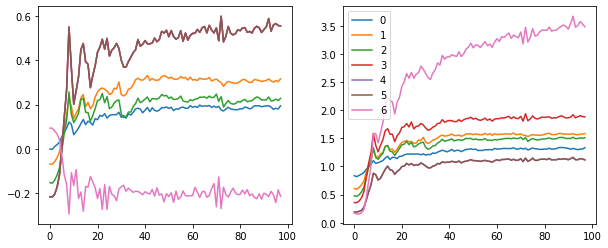

In [190]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        axs[0].plot(ms[:10])
        axs[1].plot(ss[:10])
    plt.legend(range(len(hooks)));

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        axs[0].plot(ms)
        axs[1].plot(ss)
    plt.legend(range(len(hooks)))

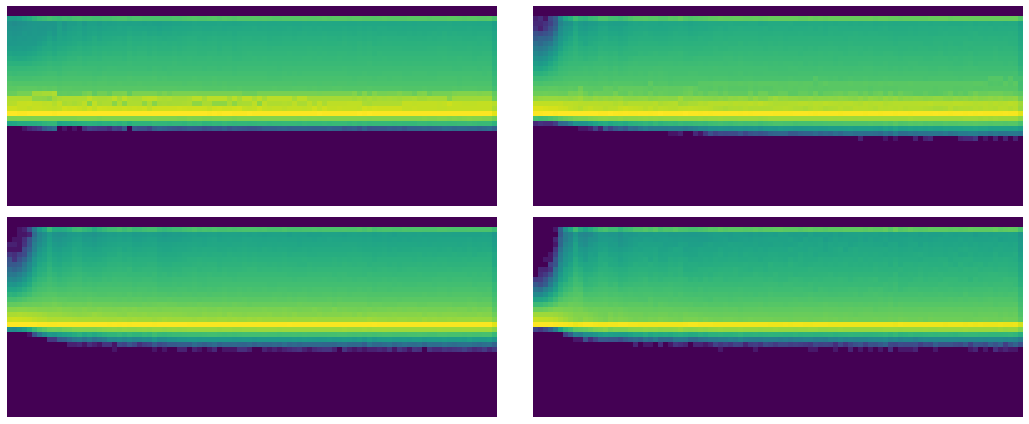

In [193]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for ax, h in zip(axs.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [198]:
get_hist(hooks[0])[19:22].size()

torch.Size([3, 98])

In [202]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0) / h1.sum(0)

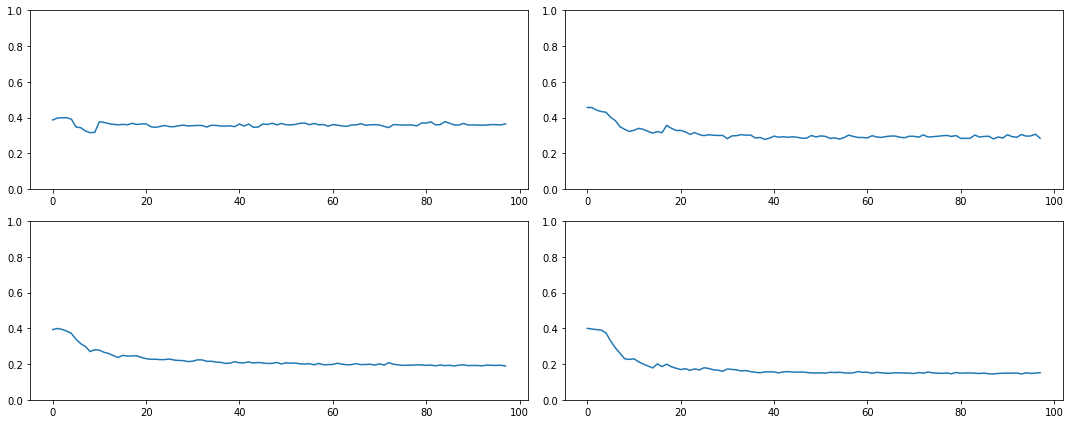

In [203]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for ax, h in zip(axs.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(bottom=0, top=1)
plt.tight_layout()

In [211]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [205]:
sched = combine_scheds([.5, .5], [sched_cos(.2, 1), sched_cos(1, .1)])

In [212]:
learn, run = get_learn_run(nfs, data, 1, conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [213]:
run.fit(8, learn)

train: [1.022121953125, tensor(0.6783, device='cuda:0')]
valid: [0.330875048828125, tensor(0.9009, device='cuda:0')]
train: [0.532432421875, tensor(0.8478, device='cuda:0')]
valid: [0.3557644775390625, tensor(0.8949, device='cuda:0')]
train: [0.17776021484375, tensor(0.9457, device='cuda:0')]
valid: [0.12644755859375, tensor(0.9613, device='cuda:0')]
train: [1.35439140625, tensor(0.5608, device='cuda:0')]
valid: [0.370959619140625, tensor(0.8830, device='cuda:0')]
train: [0.261309140625, tensor(0.9192, device='cuda:0')]
valid: [0.16030054931640625, tensor(0.9533, device='cuda:0')]
train: [0.127108359375, tensor(0.9608, device='cuda:0')]
valid: [0.11515982666015626, tensor(0.9682, device='cuda:0')]
train: [0.09372275390625, tensor(0.9712, device='cuda:0')]
valid: [0.10280643310546875, tensor(0.9712, device='cuda:0')]
train: [0.0791638671875, tensor(0.9757, device='cuda:0')]
valid: [0.09684976196289062, tensor(0.9719, device='cuda:0')]


In [214]:
learn, run = get_learn_run(nfs, data, 1, conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [215]:
run.fit(8, learn)

train: [0.95056, tensor(0.7002, device='cuda:0')]
valid: [0.6974029296875, tensor(0.7680, device='cuda:0')]
train: [0.2933128515625, tensor(0.9123, device='cuda:0')]
valid: [0.16148118896484376, tensor(0.9525, device='cuda:0')]
train: [0.19723390625, tensor(0.9409, device='cuda:0')]
valid: [0.2010322998046875, tensor(0.9366, device='cuda:0')]
train: [0.33759984375, tensor(0.8974, device='cuda:0')]
valid: [0.13010224609375, tensor(0.9637, device='cuda:0')]
train: [0.086620859375, tensor(0.9735, device='cuda:0')]
valid: [0.0847245849609375, tensor(0.9760, device='cuda:0')]
train: [0.059663857421875, tensor(0.9821, device='cuda:0')]
valid: [0.06925244140625, tensor(0.9806, device='cuda:0')]
train: [0.0450997509765625, tensor(0.9865, device='cuda:0')]
valid: [0.061684735107421874, tensor(0.9819, device='cuda:0')]
train: [0.03736818115234375, tensor(0.9891, device='cuda:0')]
valid: [0.060892938232421874, tensor(0.9823, device='cuda:0')]


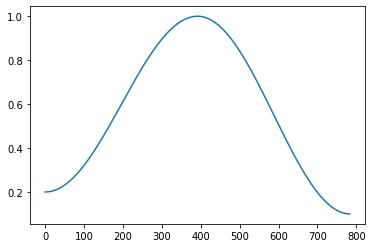

In [216]:
run.recorder.plot_lr()

In [218]:
len(learn.data.train_dl) * 8

784

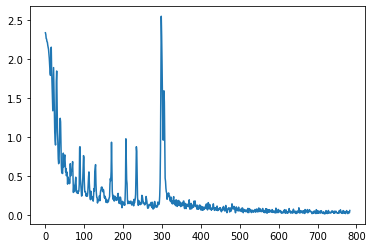

In [220]:
run.recorder.plot_loss()

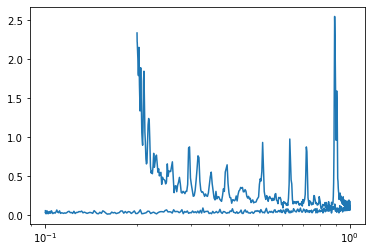

In [225]:
run.recorder.plot(pgid=0)

In [222]:
Recorder??

# fin